<a href="https://colab.research.google.com/github/Tirthankar4/Encryptix/blob/main/Encryptix_task1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'fraud-detection:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F817870%2F1399887%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240719%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240719T103725Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D02515603955e5ad55421caaff332390ace476da2aa0112993811b655625b036095a352dd4c808d2db76673b5eca0fece7faa0b185644b98cc70d448aa7f802d9f8ef9a676eabeb5168fe6c52fa5b5dd41878f32450f39289f3252c956287f566a61b5c6f11d3d4df79ab46afdc6e42b2878e5a39811e06840a6bf741bcaa05dbb85bc18ce2a3a5ed7ae83a60b0355067e0ed3c74ba992e28520ab017b8715c814b87d697a5685e3e551bfec4a9eb8379b7bc614fd23e5b5f461df92619e53dfab632c6a32d372c920c248adbe06be8974c8508e940469071354f8ea0cfde92620ad73045a743420efef972f5222c1aeca60dd48d707390dcc7d5de762c1975b1'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 211766662 bytes downloaded
Downloaded and uncompressed: fraud-detection
Data source import complete.


In [2]:
!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.0/233.0 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 8.3 MB/s eta 0:00:00


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_classif
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
import optuna
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import roc_auc_score, classification_report
import warnings

warnings.filterwarnings("ignore")

Import Datasets

In [4]:
X = pd.read_csv('/kaggle/input/fraud-detection/fraudTrain.csv', index_col = 'Unnamed: 0')
X_test = pd.read_csv('/kaggle/input/fraud-detection/fraudTest.csv', index_col = 'Unnamed: 0')

Seperate target variable to prevent data leakage

In [5]:
y = X.pop("is_fraud")
y_test = X_test.pop("is_fraud")

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.2, random_state = 69)

Remove unncessary symbols from text data for preprocessing

In [6]:
symb_remv = r'[_,/\-@#&:\s]'

obj_cols = ['merchant', 'category', 'first', 'last', 'street', 'city', 'state', 'job']

for col in obj_cols:
    X_train[col] = X_train[col].str.replace(symb_remv, '', regex=True).str.strip()
    X_valid[col] = X_valid[col].str.replace(symb_remv, '', regex=True).str.strip()
    X_test[col] = X_test[col].str.replace(symb_remv, '', regex=True).str.strip()

X_train["merchant"] = X_train["merchant"].str.replace("fraud", "", case = False)
X_valid["merchant"] = X_valid["merchant"].str.replace("fraud", "", case = False)
X_test["merchant"] = X_test["merchant"].str.replace("fraud", "", case = False)

Extracting useful features from time and date of transactions

In [7]:
X_train["trans_date_trans_time"] = pd.to_datetime(X_train["trans_date_trans_time"])
X_valid["trans_date_trans_time"] = pd.to_datetime(X_valid["trans_date_trans_time"])
X_test["trans_date_trans_time"] = pd.to_datetime(X_test["trans_date_trans_time"])

X_train["year"] = X_train["trans_date_trans_time"].dt.year
X_valid["year"] = X_valid["trans_date_trans_time"].dt.year
X_test["year"] = X_test["trans_date_trans_time"].dt.year
X_train["hour"] = X_train["trans_date_trans_time"].dt.hour
X_valid["hour"] = X_valid["trans_date_trans_time"].dt.hour
X_test["hour"] = X_test["trans_date_trans_time"].dt.hour

X_train.drop("trans_date_trans_time", axis = 1, inplace= True)
X_valid.drop("trans_date_trans_time", axis = 1, inplace= True)
X_test.drop("trans_date_trans_time", axis = 1, inplace= True)

X_train["dob"] = pd.to_datetime(X_train["dob"])
X_valid["dob"] = pd.to_datetime(X_valid["dob"])
X_test["dob"] = pd.to_datetime(X_test["dob"])

X_train["age"] = (X_train["year"] - X_train["dob"].dt.year)
X_valid["age"] = (X_valid["year"] - X_valid["dob"].dt.year)
X_test["age"] = (X_test["year"] - X_test["dob"].dt.year)

X_train.drop(["dob", "year"], axis = 1, inplace = True)
X_valid.drop(["dob", "year"], axis = 1, inplace = True)
X_test.drop(["dob", "year"], axis = 1, inplace = True)

Label Encoding Gender

In [8]:
gender = LabelEncoder()

X_train["gender"] = gender.fit_transform(X_train["gender"])
X_valid["gender"] = gender.transform(X_valid["gender"])
X_test["gender"] = gender.transform(X_test["gender"])

Frequency encoding the following columns

In [9]:
freq_encd_cols = ["merchant", "first", "last", "category", "street", "city", "state", "job", "hour", "age"]

for col in freq_encd_cols:

    freq_map = X_train[col].value_counts()

    X_train[col] = X_train[col].map(freq_map)
    X_valid[col] = X_valid[col].map(freq_map)
    X_test[col] = X_test[col].map(freq_map)

Checking mutual information scores to pick most useful features

<Axes: xlabel='MI_Score', ylabel='Feature'>

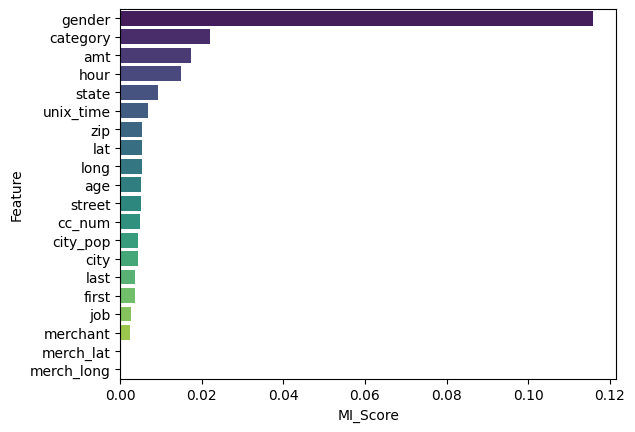

In [26]:
num_cols = [col for col in X_train.columns if X_train[col].dtype in ['int64', 'float64']]

mi_scores = mutual_info_classif(X_train[num_cols], y_train, discrete_features=False)

mi_scores_df = pd.DataFrame({'Feature': num_cols, 'MI_Score': mi_scores})
mi_scores_df = mi_scores_df.sort_values(by='MI_Score', ascending=False)

sns.barplot(x='MI_Score', y='Feature', data = mi_scores_df, palette='viridis')

Checking correlation matrix to see any unseen relations by mutual_info_classif

<Axes: >

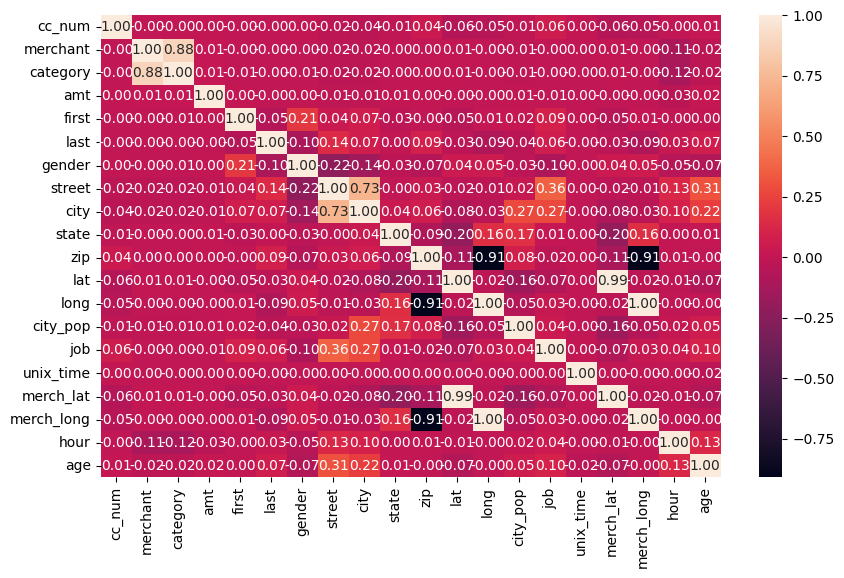

In [27]:
X_train[num_cols].corrwith(y_train)
plt.figure(figsize=(10, 6))
sns.heatmap(X_train[num_cols].corr(),annot = True, fmt = '.2f')

Picking the most important columns for training

In [10]:
X_train1 = pd.DataFrame(X_train[["gender", "category", "amt", "state", "hour", "zip", "lat", "long", "cc_num"]])
X_valid1 = pd.DataFrame(X_valid[["gender", "category", "amt", "state", "hour", "zip", "lat", "long", "cc_num"]])
X_test1 = pd.DataFrame(X_test[["gender", "category", "amt", "state", "hour", "zip", "lat", "long", "cc_num"]])

Since dataset is imbalanced, using SMOTE for oversampling minority class

In [11]:
smote = SMOTE(sampling_strategy='minority', random_state = 69, n_jobs = -1)

X_train1, y_train = smote.fit_resample(X_train1, y_train)

rus = RandomUnderSampler(random_state=69)

X_train1, y_train = rus.fit_resample(X_train1, y_train)

Baseline model to compare performance with

In [12]:
log_model = LogisticRegression(random_state = 69)

log_model.fit(X_train1, y_train)

#valid_preds = log_model.predict(X_valid1)
test_preds = log_model.predict(X_test1)

#valid_report = classification_report(y_valid, valid_preds, target_names = ["Not Fraud", "Fraud"])
test_report = classification_report(y_test, test_preds, target_names = ["Not Fraud", "Fraud"])

#print("Classification report on validation set is:")
#print(valid_report)
print("Classification report on test set is:")
print(test_report)

Classification report on test set is:
              precision    recall  f1-score   support

   Not Fraud       1.00      1.00      1.00    553574
       Fraud       0.00      0.00      0.00      2145

    accuracy                           1.00    555719
   macro avg       0.50      0.50      0.50    555719
weighted avg       0.99      1.00      0.99    555719



Optuna for best hyperparameter searching

In [14]:
def objective(trial):
    param = {
        'eval_metric': 'auc',
        'reg_lambda': trial.suggest_float('lambda', 1.0, 4.0),
        'max_depth': trial.suggest_int('max_depth', 8, 16),
        'eta': trial.suggest_float('eta', 0.01, 0.1),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'tree_method':'hist',
        'n_estimators': 1000,
        'early_stopping_rounds':100,
        'device': 'cuda',
        'random_state': 69
    }

    model = XGBClassifier(**param)
    model.fit(X_train1, y_train, eval_set = [(X_valid1, y_valid)], verbose = 100)
    preds = model.predict_proba(X_valid1)[:, 1]
    score = roc_auc_score(y_valid, preds)
    return score

xgb_study = optuna.create_study(direction='maximize')
xgb_study.optimize(objective, n_trials=10)

[I 2024-07-21 08:02:02,819] A new study created in memory with name: no-name-bae9c691-b52d-4551-934d-832d256acd0f


[0]	validation_0-auc:0.98162
[100]	validation_0-auc:0.98539
[200]	validation_0-auc:0.98851
[300]	validation_0-auc:0.99112
[400]	validation_0-auc:0.99291
[500]	validation_0-auc:0.99394
[600]	validation_0-auc:0.99458
[700]	validation_0-auc:0.99500
[800]	validation_0-auc:0.99527
[900]	validation_0-auc:0.99556
[999]	validation_0-auc:0.99566


[I 2024-07-21 08:02:47,023] Trial 0 finished with value: 0.9956689066832277 and parameters: {'lambda': 3.1653571555310336, 'max_depth': 14, 'eta': 0.01738019076070401, 'subsample': 0.662034752060876, 'colsample_bylevel': 0.8853960656503972, 'colsample_bytree': 0.6195483002653028}. Best is trial 0 with value: 0.9956689066832277.


[0]	validation_0-auc:0.98050
[100]	validation_0-auc:0.99462
[200]	validation_0-auc:0.99564
[300]	validation_0-auc:0.99564
[330]	validation_0-auc:0.99561


[I 2024-07-21 08:03:06,040] Trial 1 finished with value: 0.9957336838714589 and parameters: {'lambda': 3.274430533818742, 'max_depth': 16, 'eta': 0.09802581723845884, 'subsample': 0.8016594559672807, 'colsample_bylevel': 0.6855057400368263, 'colsample_bytree': 0.6203466510931965}. Best is trial 1 with value: 0.9957336838714589.


[0]	validation_0-auc:0.97988
[100]	validation_0-auc:0.98617
[200]	validation_0-auc:0.98936
[300]	validation_0-auc:0.99109
[400]	validation_0-auc:0.99309
[500]	validation_0-auc:0.99420
[600]	validation_0-auc:0.99460
[700]	validation_0-auc:0.99506
[800]	validation_0-auc:0.99530
[900]	validation_0-auc:0.99545
[999]	validation_0-auc:0.99557


[I 2024-07-21 08:03:41,113] Trial 2 finished with value: 0.9955697337924241 and parameters: {'lambda': 2.4386471557841585, 'max_depth': 12, 'eta': 0.01625272386251829, 'subsample': 0.5070368795641942, 'colsample_bylevel': 0.6857712212029069, 'colsample_bytree': 0.7287443838981207}. Best is trial 1 with value: 0.9957336838714589.


[0]	validation_0-auc:0.97998
[100]	validation_0-auc:0.98654
[200]	validation_0-auc:0.98938
[300]	validation_0-auc:0.99175
[400]	validation_0-auc:0.99331
[500]	validation_0-auc:0.99444
[600]	validation_0-auc:0.99504
[700]	validation_0-auc:0.99530
[800]	validation_0-auc:0.99551
[900]	validation_0-auc:0.99561
[999]	validation_0-auc:0.99568


[I 2024-07-21 08:04:29,374] Trial 3 finished with value: 0.9956854966491183 and parameters: {'lambda': 2.2099422884464954, 'max_depth': 15, 'eta': 0.01612335517797274, 'subsample': 0.5536986439109601, 'colsample_bylevel': 0.8193345717500193, 'colsample_bytree': 0.6729515815728941}. Best is trial 1 with value: 0.9957336838714589.


[0]	validation_0-auc:0.98179
[100]	validation_0-auc:0.99332
[200]	validation_0-auc:0.99534
[300]	validation_0-auc:0.99575
[400]	validation_0-auc:0.99576
[446]	validation_0-auc:0.99574


[I 2024-07-21 08:04:50,437] Trial 4 finished with value: 0.9957723507519649 and parameters: {'lambda': 3.9219379153588454, 'max_depth': 14, 'eta': 0.05145265047360601, 'subsample': 0.6965886886794923, 'colsample_bylevel': 0.8418610791666614, 'colsample_bytree': 0.833481511815763}. Best is trial 4 with value: 0.9957723507519649.


[0]	validation_0-auc:0.97190
[100]	validation_0-auc:0.99189
[200]	validation_0-auc:0.99406
[300]	validation_0-auc:0.99515
[400]	validation_0-auc:0.99547
[500]	validation_0-auc:0.99554
[596]	validation_0-auc:0.99552


[I 2024-07-21 08:05:18,354] Trial 5 finished with value: 0.9955543787735206 and parameters: {'lambda': 3.912401665954203, 'max_depth': 15, 'eta': 0.05029689754189564, 'subsample': 0.8225752309640475, 'colsample_bylevel': 0.5176626916743752, 'colsample_bytree': 0.8276636928838701}. Best is trial 4 with value: 0.9957723507519649.


[0]	validation_0-auc:0.95813
[100]	validation_0-auc:0.98468
[200]	validation_0-auc:0.99110
[300]	validation_0-auc:0.99383
[400]	validation_0-auc:0.99479
[500]	validation_0-auc:0.99519
[600]	validation_0-auc:0.99529
[700]	validation_0-auc:0.99534
[775]	validation_0-auc:0.99533


[I 2024-07-21 08:05:50,233] Trial 6 finished with value: 0.9953886759902215 and parameters: {'lambda': 1.9315651147148787, 'max_depth': 13, 'eta': 0.049992056441230094, 'subsample': 0.8358173125404307, 'colsample_bylevel': 0.941013567939375, 'colsample_bytree': 0.5012312394159336}. Best is trial 4 with value: 0.9957723507519649.


[0]	validation_0-auc:0.97687
[100]	validation_0-auc:0.98840
[200]	validation_0-auc:0.98972
[300]	validation_0-auc:0.99082
[400]	validation_0-auc:0.99170
[500]	validation_0-auc:0.99250
[600]	validation_0-auc:0.99314
[700]	validation_0-auc:0.99346
[800]	validation_0-auc:0.99390
[900]	validation_0-auc:0.99422
[999]	validation_0-auc:0.99452


[I 2024-07-21 08:06:22,576] Trial 7 finished with value: 0.9945194420618945 and parameters: {'lambda': 1.0980481503192046, 'max_depth': 11, 'eta': 0.012430449322278308, 'subsample': 0.9494435270668979, 'colsample_bylevel': 0.6693959373168668, 'colsample_bytree': 0.9134798440680815}. Best is trial 4 with value: 0.9957723507519649.


[0]	validation_0-auc:0.96850
[100]	validation_0-auc:0.99105
[200]	validation_0-auc:0.99453
[300]	validation_0-auc:0.99546
[400]	validation_0-auc:0.99569
[500]	validation_0-auc:0.99565
[518]	validation_0-auc:0.99562


[I 2024-07-21 08:06:35,646] Trial 8 finished with value: 0.9957143836699447 and parameters: {'lambda': 2.9739422725484013, 'max_depth': 8, 'eta': 0.08865949150394979, 'subsample': 0.9103081688566445, 'colsample_bylevel': 0.8523880214263699, 'colsample_bytree': 0.7034322361305752}. Best is trial 4 with value: 0.9957723507519649.


[0]	validation_0-auc:0.97696
[100]	validation_0-auc:0.98980
[200]	validation_0-auc:0.99368
[300]	validation_0-auc:0.99481
[400]	validation_0-auc:0.99514
[500]	validation_0-auc:0.99525
[599]	validation_0-auc:0.99519


[I 2024-07-21 08:07:00,170] Trial 9 finished with value: 0.9952459130503333 and parameters: {'lambda': 2.4976626920771365, 'max_depth': 13, 'eta': 0.09189765089828046, 'subsample': 0.8120367582571587, 'colsample_bylevel': 0.5602576145296283, 'colsample_bytree': 0.5653169126199135}. Best is trial 4 with value: 0.9957723507519649.


In [15]:
xgb_study.best_params

{'lambda': 3.9219379153588454,
 'max_depth': 14,
 'eta': 0.05145265047360601,
 'subsample': 0.6965886886794923,
 'colsample_bylevel': 0.8418610791666614,
 'colsample_bytree': 0.833481511815763}

Training optimal XgBoost model and checking performance

In [19]:
xgb_model = XGBClassifier(reg_lambda = 3.9219379153588454, max_depth = 14, eta = 0.05145265047360601, subsample = 0.6965886886794923, colsample_bylevel = 0.8418610791666614,
                      colsample_bytree = 0.833481511815763, eval_metric = 'auc', n_estimators = 1969, device = 'cuda', early_stopping_rounds = 96, random_state = 69)

xgb_model.fit(X_train1, y_train, eval_set = [(X_valid1, y_valid)], verbose = False)

#valid_preds = xgb_model.predict(X_valid1)
test_preds = xgb_model.predict(X_test1)

#valid_report = classification_report(y_valid, valid_preds, target_names = ["Not Fraud", "Fraud"])
test_report = classification_report(y_test, test_preds, target_names = ["Not Fraud", "Fraud"])

#print("Classification report on validation set is:")
#print(valid_report)
print("Classification report on test set is:")
print(test_report)

Classification report on test set is:
              precision    recall  f1-score   support

   Not Fraud       1.00      1.00      1.00    553574
       Fraud       0.68      0.72      0.70      2145

    accuracy                           1.00    555719
   macro avg       0.84      0.86      0.85    555719
weighted avg       1.00      1.00      1.00    555719

